In [3]:
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from keras import layers, callbacks, models    
import pandas as pd 
import numpy as np

In [5]:
df = pd.read_csv('ev_charging_sessions.csv')
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['hour_start'] = df['start_time'].dt.hour
df['hour_end'] = df['end_time'].dt.hour
df['start_date'] = df['start_time'].dt.date
df['end_date'] = df['end_time'].dt.date

X = df.copy() 
X.dropna(subset='energy_kWh', axis=0, inplace=True)
y = X.energy_kWh 
X.drop('energy_kWh', axis=1, inplace=True)
X.drop('start_time', axis=1, inplace=True)
X.drop('end_time', axis=1, inplace=True)

X = X[['duration_min', 'hour_start', 'hour_end', 'session_day', 'session_type']]

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

categorical_cols = [col for col in X_train if X_train[col].nunique() < 10 and 
                    X_train[col].dtype == "object"] #for OneHotEncoder(handle_unknown='ignore')

numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

numerical_transformer = make_pipeline(SimpleImputer(strategy='constant'), StandardScaler()) 
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore')) 


preprocessor = make_column_transformer(
    (numerical_transformer, numerical_cols),
    (categorical_transformer, categorical_cols)
)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [13]:
model = models.Sequential([
    layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae']) # use mse for loss to punish outliers, and mae for easier interpretation

early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)

c:\Users\bvhaw\anaconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2152.6350 - mae: 42.2293 - val_loss: 2109.0386 - val_mae: 41.3643
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1993.4806 - mae: 41.8850 - val_loss: 2080.1372 - val_mae: 41.1822
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1945.9373 - mae: 41.7667 - val_loss: 2054.4636 - val_mae: 41.0161
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1866.5999 - mae: 40.9257 - val_loss: 2032.4695 - val_mae: 40.8590
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1921.0076 - mae: 41.4540 - val_loss: 2013.4807 - val_mae: 40.6993
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1873.5040 - mae: 40.9299 - val_loss: 1995.4590 - val_mae: 40.5173
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1869.2207 - mae: 40.9049 - val_loss: 1978.5571 - val_mae: 40.3218
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1855.4988 - mae: 40.7510 - val_loss: 1961.3114 - val_mae: 40.1098
Epoch 9/2

<Axes: title={'center': 'MAE (Metric)'}>

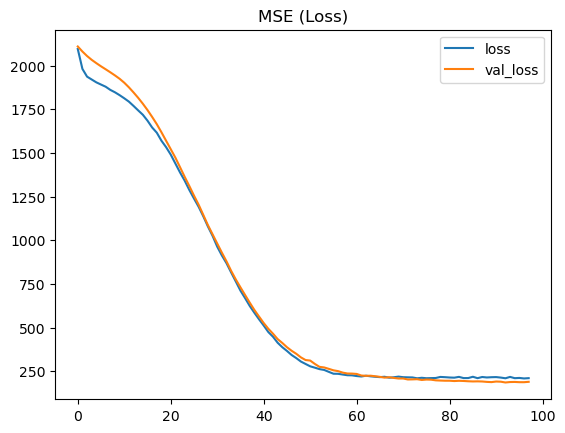

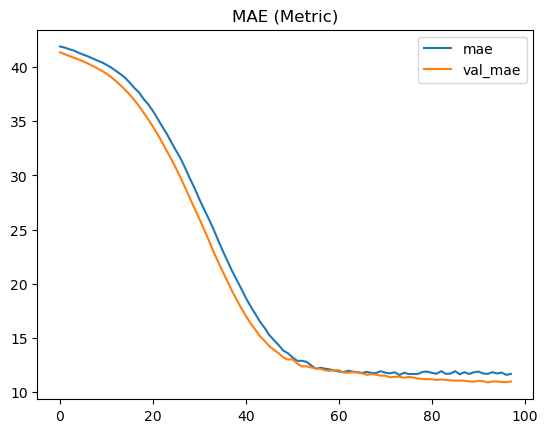

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=512, epochs=200, callbacks=[early_stopping])

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(title="MSE (Loss)")
history_df[['mae', 'val_mae']].plot(title="MAE (Metric)")